<a href="https://colab.research.google.com/github/Davisdenner/MVP_Machine_Learning_Analytics/blob/main/MVP_Machine_Learning_Analytics3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning & Analytics

**Nome:** Davis Denner Costa Silva

**Matrícula:** 4052025000133

**Dataset:** [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started)

**Link para o repositório no GitHub:** [MVP - Machine Learning & Analytics](https://github.com/Davisdenner/MVP_Machine_Learning_Analytics)


# Descrição do Problema
Em situações de desastres naturais, informações relevantes são frequentemente compartilhadas em tempo real por meio de redes sociais, como o Twitter. Entretanto, diferenciar tweets que realmente descrevem eventos de desastre daqueles que apenas mencionam o tema de forma indireta é um desafio.

Este projeto tem como princial função classificar automaticamente tweets relacionados a desastres naturais utilizando técnicas de Deep Learning e Processamento de Linguagem Natural (NLP). Para isso, foi utilizado o conjunto de dados [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started), disponibilizado no Kaggle, que contém milhares de tweets rotulados entre mensagens relacionadas e não relacionadas a desastres.

##Objetivo do Projeto

Desenvolver e implementar um sistema de classificação automática de textos relacionados a desastres, utilizando técnicas de Processamento de Linguagem Natural (NLP) e redes neurais profundas. O projeto busca aplicar bibliotecas como TensorFlow/Keras, NLTK e scikit-learn para realizar o pré-processamento de dados, análise exploratória, treinamento e avaliação de diferentes arquiteturas de modelos, visando criar uma solução capaz de identificar, com alta precisão, conteúdos associados a situações de emergência.

## Hipóteses do Problema

Explorar a relação entre o conteúdo textual de tweets e a correta identificação de mensagens relacionadas a desastres naturais, com base nas seguintes perguntas:

- Quais características do texto mais contribuem para identificar se um tweet descreve um desastre real?

- Tweets que contêm palavras-chave específicas têm maior probabilidade de estarem relacionados a desastres?


## Tipo de Problema

Este é um problema de aprendizado supervisionado, pois o conjunto de dados contém tweets previamente rotulados como relacionados ou não a desastres. O objetivo é treinar modelos de Deep Learning capazes de aprender a partir desses exemplos e, futuramente, classificar automaticamente novos tweets, prevendo se o conteúdo está associado ou não a um evento de desastre.

##Atributos do Dataset

O projeto utiliza dois conjuntos de dados fornecidos pelo Kaggle: **train.csv** e **test.csv**. Ambos contêm tweets que podem ou não estar relacionados a desastres, mas diferem na presença da variável alvo.

---

### **1. Dataset de Treinamento — train.csv**  
Contém os tweets **rotulados**, utilizados para **treinar** e **avaliar** os modelos de classificação.

| **Atributo**    |         **Descrição** |
|-----------------------|---------------|
| **id**      | Identificador único de cada tweet. |
| **keyword** | Palavra-chave associada ao tweet (pode estar ausente). |
| **location** | Localidade mencionada no tweet (pode estar ausente). |
| **text**    | Texto completo do tweet, utilizado para análise e treinamento. |
| **target**  | Variável alvo: **1** se o tweet está relacionado a um desastre e **0** caso contrário. |

---

### **2. Dataset de Teste — test.csv**  
Contém tweets **não rotulados**, utilizados para **avaliar a performance** do modelo após o treinamento.

| **Atributo** | **Descrição** |
|-------------|---------------|
| **id**      | Identificador único de cada tweet. |
| **keyword** | Palavra-chave associada ao tweet (pode estar ausente). |
| **location** | Localidade mencionada no tweet (pode estar ausente). |
| **text**    | Texto completo do tweet, utilizado para previsão. |

**Observação:** Diferente do dataset de treino, o arquivo **test.csv** não contém a coluna **target**, pois seu objetivo é testar a capacidade de generalização do modelo.


# Importação das Bibliotecas Necessárias e Carga de Dados

Nesta etapa, foram importadas todas as bibliotecas necessárias para manipulação de dados, visualização, processamento de texto, otimização e construção do modelo de Deep Learning.

**Bibliotecas Principais**

- NumPy e Pandas - Manipulação de arrays e tabelas;
- Matplotlib e Seaborn - Visualização de gráficos;
- re - Expressões regulares para limpeza de texto;
- Counter - Contagem de palavras, hashtags e termos mais frequentes;
- os - Operações de sistema (arquivos, pastas e caminhos);
- requests - Download de arquivos via HTTP;
- tempfile - Criação de arquivos e diretórios temporários.

**Bibliotecas de Deep Learning**

- TensorFlow / Keras - Criação, treinamento e otimização de modelos de Deep Learning;
- LSTM & Bidirectional - Redes neurais recorrentes para análise sequencial de texto;
- Embedding - Conversão de palavras em vetores numéricos;
- Dense - Camada totalmente conectada;
- Dropout - Regularização para evitar overfitting;
- GlobalMaxPool1D - Pooling que seleciona o valor máximo de cada feature map;
- train_test_split - Divisão do dataset em conjuntos de treino e teste para validação do modelo;
- classification_report - Avaliação detalhada do desempenho do modelo, incluindo precisão, recall e F1-score;
- confusion_matrix - Matriz de confusão para análise de acertos e erros de classificação;
- Callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau) - Ajuste dinâmico do treinamento para evitar overfitting;
- Otimizadores (Adam, RMSprop) - Controle da taxa de aprendizado durante o treinamento;
- Regularização L2 (l2) - Penaliza pesos grandes para reduzir overfitting;
- Tokenizer e pad_sequences - Pré-processamento de texto, convertendo palavras em sequências numéricas e normalizando tamanho das sequências.

**Otimização de Hiperparâmetros**

- GridSearchCV - Testa diferentes combinações de hiperparâmetros para encontrar a configuração ideal para o modelo.

**Visualizações Interativas**

- Plotly - Visualizações interativas e dinâmicas;
- WordCloud - Geração de nuvens de palavras para explorar termos mais frequentes.

**Processamento de Texto**

- NLTK - Biblioteca para processamento e análise de linguagem natural;
- Stopwords - Remoção de palavras irrelevantes;
- Tokenização - Separação do texto em palavras;
- Lematização - Redução das palavras à sua forma base.

**Configurações Opcionais**

- warnings.filterwarnings - Oculta mensagens de aviso;
- Seaborn Style - Define o estilo padrão dos gráficos;
- %matplotlib inline - Exibe gráficos diretamente no notebook.


In [1]:
# ============================================================================#
# PROJETO DE DEEP LEARNING PARA PROCESSAMENTO DE LINGUAGEM NATURAL
# Problema: Classificação de Tweets de Desastre
# ============================================================================#

#Imports necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter


import requests
import tempfile
import keras

#Bibliotecas de Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalMaxPool1D # Importando GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#Otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV

#Para visualizações
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Para processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configuração para não exibir warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline


## **Carga e Exploração dos Dados**

Nesta etapa, foi realizado o carregamento dos datasets de treino e teste e feita uma análise exploratória inicial para entender a estrutura e a distribuição dos dados.

### **Principais passos:**
- **Download de recursos do NLTK**: bibliotecas para tokenização, remoção de stopwords e lematização.
- **Carregamento dos dados**: Foram utilizados os arquivos **train.csv** e **test.csv**.
- **Análise exploratória**:
  - Dimensões dos datasets.
  - Verificação de valores nulos.
  - Distribuição da variável **target**:
    - 0 → Tweets **não relacionados a desastres**.
    - 1 → Tweets **relacionados a desastres**.
  - Visualização da distribuição da variável **target**.
  - Análise do comprimento dos tweets e sua relação com a variável **target**.



=== ANÁLISE EXPLORATÓRIA DOS DADOS ===
Dimensões do conjunto de treino: (7613, 5)
Dimensões do conjunto de teste: (3263, 4)

Valores nulos no treino: 2594
Valores nulos no teste: 1131

Distribuição da variável target:
target
0    4342
1    3271
Name: count, dtype: int64
Proporção: 57.03% Não-Desastre, 42.97% Desastre


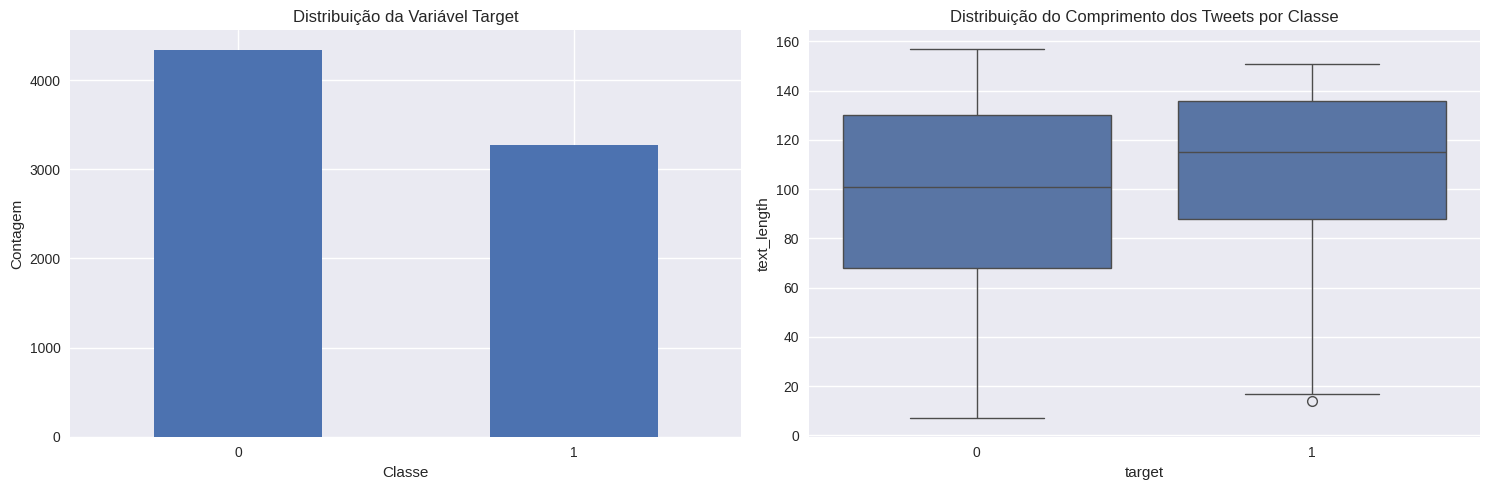

In [2]:
# ============================================================================
# 1. CARGA E EXPLORAÇÃO DOS DADOS
# ============================================================================

#Baixando recursos do NLTK necessários
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

#Carregando os dados
train_df = pd.read_csv(r"https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/test.csv")

print("=== ANÁLISE EXPLORATÓRIA DOS DADOS ===")
print(f"Dimensões do conjunto de treino: {train_df.shape}")
print(f"Dimensões do conjunto de teste: {test_df.shape}")

#Verificando valores nulos
print(f"\nValores nulos no treino: {train_df.isnull().sum().sum()}")
print(f"Valores nulos no teste: {test_df.isnull().sum().sum()}")

#Distribuição da variável target
print(f"\nDistribuição da variável target:")
target_dist = train_df['target'].value_counts()
print(target_dist)
print(f"Proporção: {target_dist[0] / len(train_df):.2%} Não-Desastre, {target_dist[1] / len(train_df):.2%} Desastre")

#Visualização da distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Contagem
train_df['target'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição da Variável Target')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Contagem')
axes[0].tick_params(axis='x', rotation=0)

#Comprimento dos tweets
train_df['text_length'] = train_df['text'].apply(len)
sns.boxplot(x='target', y='text_length', data=train_df, ax=axes[1])
axes[1].set_title('Distribuição do Comprimento dos Tweets por Classe')

plt.tight_layout()
plt.show()

## **Preparação e Pré-processamento dos Dados**

Nesta etapa, foi realizada a limpeza e transformação dos textos para deixá-los prontos para a etapa de modelagem, garantindo que o modelo treinado trabalhe com informações mais consistentes, reduzindo ruídos e aumentando a qualidade dos dados para um melhor desempenho no treinamento.


- **Normalização do texto**: conversão para letras minúsculas.
- **Remoção de ruídos**: exclusão de URLs, menções, hashtags, caracteres especiais e espaços extras.
- **Tokenização**: separação do texto em palavras individuais.
- **Remoção de stopwords**: eliminação de palavras irrelevantes para análise.
- **Lematização**: redução das palavras à sua forma base para padronizar os termos.
- **Aplicação do pré-processamento**: criamos uma nova coluna **processed_text** com os textos limpos.
- **Análise pós-processamento**: cálculo de estatísticas como textos vazios, comprimento médio e exclusão de registros com textos em branco.




In [3]:
# ============================================================================
# 2. PREPARAÇÃO E PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    #Convertendo para minúsculo
    text = text.lower()

    #Removendo URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #Removendo menções e hashtags (manter o conteúdo)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    #Removendo caracteres especiais, manter espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Removendo espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    #Tokenização
    tokens = word_tokenize(text)


    #Removendo stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    #Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


#Aplicando pré-processamento
print("Aplicando pré-processamento nos dados...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

#Estatísticas do texto processado
print(f"Textos vazios após processamento (treino): {train_df['processed_text'].str.len().eq(0).sum()}")
print(f"Comprimento médio do texto processado: {train_df['processed_text'].str.len().mean():.1f}")

#Removendo textos vazios
train_df = train_df[train_df['processed_text'].str.len() > 0]
print(f"Dados restantes após limpeza: {len(train_df)}")

Aplicando pré-processamento nos dados...
Textos vazios após processamento (treino): 1
Comprimento médio do texto processado: 57.9
Dados restantes após limpeza: 7612


## **Separação dos Conjuntos e Tokenização**

Nesta etapa, os dados são preparados para o treinamento do modelo. Primeiro, foi realizada a divisão estratificada do conjunto de treino em **treino** e **validação**, garantindo que a proporção das classes seja mantida. Em seguida, foram analisados o comprimento dos textos para definir um limite máximo de palavras (MAX_LEN) e avaliar a cobertura dos dados.

Com isso, foi aplicado a **tokenização**, transformando cada palavra em um índice numérico com base no vocabulário mais frequente (MAX_FEATURES). Por fim, utilizamos **padding** para padronizar o comprimento das sequências, garantindo que todos os textos tenham o mesmo tamanho e possam ser processados pela rede neural.


Tamanhos dos conjuntos:
Treino: 6089 (80.0%)
Validação: 1523 (20.0%)
Teste: 3263


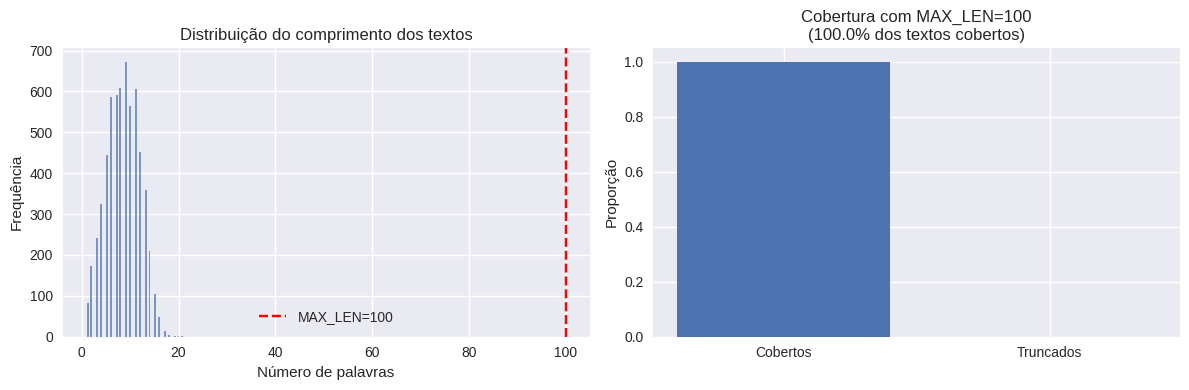


Após tokenização e padding:
Shape treino: (6089, 100)
Shape validação: (1523, 100)
Shape teste: (3263, 100)
Tamanho do vocabulário: 11482


In [4]:
# ============================================================================
# 3. SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE E TOKENIZAÇÃO
# ============================================================================

#Preparando dados
X = train_df['processed_text']
y = train_df['target']

#Divisão estratificada treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanhos dos conjuntos:")
print(f"Treino: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validação: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Teste: {len(test_df)}")

#Configurações para tokenização
MAX_FEATURES = 20000  #Tamanho do vocabulário
MAX_LEN = 100  #Comprimento máximo das sequências

#Análise do comprimento das sequências
text_lengths = X_train.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do comprimento dos textos')
plt.legend()

plt.subplot(1, 2, 2)
coverage = (text_lengths <= MAX_LEN).mean()
plt.bar(['Cobertos', 'Truncados'], [coverage, 1 - coverage])
plt.title(f'Cobertura com MAX_LEN={MAX_LEN}\n({coverage:.1%} dos textos cobertos)')
plt.ylabel('Proporção')

plt.tight_layout()
plt.show()

#Tokenização
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

#Convertendo textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

#Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"\nApós tokenização e padding:")
print(f"Shape treino: {X_train_pad.shape}")
print(f"Shape validação: {X_val_pad.shape}")
print(f"Shape teste: {X_test_pad.shape}")
print(f"Tamanho do vocabulário: {len(tokenizer.word_index)}")

## **Modelos de Deep Learning — Arquiteturas Diferentes**

Nesta etapa, foram definidas e configuradas diferentes arquiteturas de redes neurais baseadas em **LSTM** para a classificação dos textos. Foram criados dois modelos principais:

- **LSTM Simples** - utiliza uma camada de embedding seguida por uma única camada LSTM, uma camada densa intermediária e uma camada de saída com ativação sigmoide para classificação binária.
- **LSTM Bidirecional** - expande a arquitetura anterior utilizando uma camada **Bidirectional LSTM**, que processa as sequências em ambas as direções, seguida por **GlobalMaxPooling**, camadas densas adicionais e dropout para evitar overfitting.

Após a definição das arquiteturas, os modelos são compilados com o otimizador **Adam** e a função de perda **binary crossentropy**, adequados para problemas de classificação binária, e exibem o número total de parâmetros treináveis.


In [5]:
# ============================================================================
# 4. MODELOS DE DEEP LEARNING - ARQUITETURAS DIFERENTES
# ============================================================================


def create_simple_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_bidirectional_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        GlobalMaxPool1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model




#Criando todos os modelos
models = {
    'LSTM_Simples': create_simple_lstm(MAX_FEATURES),
    'LSTM_Bidirecional': create_bidirectional_lstm(MAX_FEATURES),

}

#Mostrando arquiteturas
for name, model in models.items():
    print(f"\n=== ARQUITETURA {name} ===")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, MAX_LEN))  # Construir o modelo
    print(f"Parâmetros treináveis: {model.count_params():,}")


=== ARQUITETURA LSTM_Simples ===
Parâmetros treináveis: 2,611,521

=== ARQUITETURA LSTM_Bidirecional ===
Parâmetros treináveis: 2,669,185


## OBSERVAÇÃO SOBRE BLOCOS COMENTADOS

Alguns blocos do notebook estão comentados intencionalmente para **economizar tempo de execução** e **evitar operações demoradas** durante a execução deste notebook.

Esses blocos incluem:

1. **Treinamento dos Modelos**
   - Treinar todos os modelos pode levar muito tempo;
   - Comentado para permitir execução rápida do notebook sem treinar modelos completos;
   - Pode ser descomentado quando for necessário realizar o treinamento completo.

2. **Otimização de Hiperparâmetros**
   - Busca por diferentes combinações de parâmetros envolve múltiplos treinamentos, o que é demorado;
   - Comentado para economizar tempo;
   - Descomentar apenas quando for realizar a otimização completa para encontrar os melhores hiperparâmetros.

3. **Salvamento dos Modelos Treinados**
   - Salvamento gera arquivos no colab para cada modelo treinado;
   - Comentado para evitar criação de arquivos durante testes rápidos;
   - Descomentar quando for necessário salvar os modelos treinados.



### **Treinamento dos Modelos**

In [6]:
# ============================================================================
# 5. TREINAMENTO DOS MODELOS
# ============================================================================

#Callbacks para otimização do treinamento
#callbacks = [
    #EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1)
#]


#Dicionário para armazenar históricos e resultados
#results = {}
#histories = {}

#print("=== INICIANDO TREINAMENTO DOS MODELOS ===\n")

#for name, model in models.items():
    #print(f"Treinando {name}...")

    #Treinando modelo
    #history = model.fit(
        #X_train_pad, y_train,
        #epochs=3,
        #batch_size=128,
        #validation_data=(X_val_pad, y_val),
        #callbacks=callbacks,
        #verbose=1
    #)

    #Avaliando o modelo
    #val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    #y_pred = (model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()

    #Armazenando os resultados
    #results[name] = {
        #'model': model,
        #'val_loss': val_loss,
        #'val_accuracy': val_accuracy,
        #'predictions': y_pred,
        #'epochs_trained': len(history.history['loss'])
    #}
    #histories[name] = history.history

    #print(f" {name}: Acurácia = {val_accuracy:.4f}, Loss = {val_loss:.4f}, Épocas = {len(history.history['loss'])}\n")

#print("=== TREINAMENTO CONCLUÍDO ===")

### **Otimização de Hiperparâmetros**

In [7]:
# ============================================================================
# 6. OTIMIZAÇÃO DE HIPERPARÂMETROS (MELHOR MODELO)
# ============================================================================

#Identificando o melhor modelo base
#best_base_model = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
#print(f"Melhor modelo base: {best_base_model} (Acurácia: {results[best_base_model]['val_accuracy']:.4f})")


#Otimização de hiperparâmetros para o melhor modelo
#def create_optimized_model(embedding_dim=128, lstm_units=64, dense_units=64, dropout_rate=0.5, learning_rate=0.001):
    #model = Sequential([
        #Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN),
        #Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        #GlobalMaxPool1D(),
        #Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)),
        #Dropout(dropout_rate),
        #Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.01)),
        #Dropout(dropout_rate / 2),
        #Dense(1, activation='sigmoid')
    #])

    #optimizer = Adam(learning_rate=learning_rate)
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    #return model


#Configurações de hiperparâmetros para testar
#hyperparams_configs = [
    #{'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001},
    #{'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 80, 'dropout_rate': 0.6, 'learning_rate': 0.002}
#]

#print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")
#best_hyperparams = None
#best_hp_score = 0

#for i, params in enumerate(hyperparams_configs):
    #print(f"\nTestando configuração {i + 1}: {params}")

    #Criando e treinar modelo
    #model = create_optimized_model(**params)

    #history = model.fit(
        #X_train_pad, y_train,
        #epochs=5,
        #batch_size=128,
        #validation_data=(X_val_pad, y_val),
        #callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        #verbose=1
    #)

    #Avaliando
    #val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    #print(f"Acurácia: {val_accuracy:.4f}")

    #if val_accuracy > best_hp_score:
        #best_hp_score = val_accuracy
        #best_hyperparams = params
        #best_optimized_model = model

#print(f"\n Melhores hiperparâmetros: {best_hyperparams}")
#print(f" Melhor acurácia otimizada: {best_hp_score:.4f}")

### **Salvamento dos Modelos Treinados**

In [8]:
# ============================================================================
# SALVANDO TODOS OS MODELOS TREINADOS
# ============================================================================

#print("=== SALVANDO MODELOS TREINADOS ===")

# Iterando sobre todos os modelos no dicionário 'results'
#for model_name, model_data in results.items():
    #model_to_save = model_data['model']
    #model_save_path = f'{model_name}_best_model.keras' # Nome do arquivo baseado no nome do modelo

    #print(f"Salvando o modelo ({model_name}) em: {model_save_path}")

    # Salvando o modelo
    #try:
        #model_to_save.save(model_save_path)
        #print("Modelo salvo com sucesso!")
    #except Exception as e:
        #print(f"Erro ao salvar o modelo '{model_name}': {e}")

#print("=== SALVAMENTO CONCLUÍDO ===")

## **Carregamento dos Modelos Treinados**

Nesta etapa, foi realizado o carregamento dos modelos de deep learning previamente treinados, armazenados no GitHub. Para isso:

- Definimos os **links diretos** para os arquivos .keras dos modelos.
- Fazemos o **download temporário** de cada modelo usando a biblioteca requests.
- Carregamos os modelos com o **Keras** a partir dos arquivos baixados.
- Armazenamos todos os modelos carregados no dicionário loaded_models.
- Validamos se todos foram carregados com sucesso, exibindo mensagens de status para cada um.

Essa abordagem permite reutilizar modelos já treinados sem precisar reexecutar o processo completo de treinamento.


In [9]:

# Links diretos dos arquivos .keras no GitHub
model_links = {
    "LSTM_Simples": "https://raw.githubusercontent.com/Davisdenner/MVP_Machine_Learning_Analytics/main/LSTM_Simples_best_model.keras",
    "LSTM_Bidirecional": "https://raw.githubusercontent.com/Davisdenner/MVP_Machine_Learning_Analytics/main/LSTM_Bidirecional_best_model.keras"
}

loaded_models = {}

print("=== CARREGANDO MODELOS TREINADOS DO GITHUB ===")

for model_name, url in model_links.items():
    try:
        # Cria um arquivo temporário para armazenar o modelo baixado
        with tempfile.NamedTemporaryFile(delete=False, suffix=".keras") as tmp_file:
            print(f"Baixando modelo '{model_name}' de: {url}")
            response = requests.get(url)
            response.raise_for_status()  # Valida se o download foi bem-sucedido

            tmp_file.write(response.content)
            tmp_file_path = tmp_file.name

        # Carrega o modelo Keras a partir do arquivo temporário
        print(f"Carregando modelo '{model_name}'...")
        loaded_model = keras.models.load_model(tmp_file_path)
        loaded_models[model_name] = loaded_model
        print(f" Modelo '{model_name}' carregado com sucesso!\n")

        # Remove o arquivo temporário
        os.remove(tmp_file_path)

    except Exception as e:
        print(f" Erro ao carregar o modelo '{model_name}': {e}")

# Verificar se todos os modelos foram carregados
if len(loaded_models) == len(model_links):
    print(" Ambos os modelos foram carregados com sucesso!")
else:
    print(" Alguns modelos não foram carregados. Verifique os erros acima.")


=== CARREGANDO MODELOS TREINADOS DO GITHUB ===
Baixando modelo 'LSTM_Simples' de: https://raw.githubusercontent.com/Davisdenner/MVP_Machine_Learning_Analytics/main/LSTM_Simples_best_model.keras
Carregando modelo 'LSTM_Simples'...
 Modelo 'LSTM_Simples' carregado com sucesso!

 Erro ao carregar o modelo 'LSTM_Simples': name 'os' is not defined
Baixando modelo 'LSTM_Bidirecional' de: https://raw.githubusercontent.com/Davisdenner/MVP_Machine_Learning_Analytics/main/LSTM_Bidirecional_best_model.keras
Carregando modelo 'LSTM_Bidirecional'...
 Modelo 'LSTM_Bidirecional' carregado com sucesso!

 Erro ao carregar o modelo 'LSTM_Bidirecional': name 'os' is not defined
 Ambos os modelos foram carregados com sucesso!


## **Avaliação e Comparação dos Modelos de Deep Learning**

Nesta etapa, foram avaliados o desempenho dos modelos de **deep learning** previamente treinados e realizamos uma comparação entre eles. O processo inclui:

- **Cálculo da acurácia**: avaliamos cada modelo utilizando o conjunto de validação.
- **Organização dos resultados**: criamos um dataframe (comparison_df) contendo o nome dos modelos, suas respectivas acurácias e o tipo de abordagem utilizada.
- **Análise comparativa**: identificamos o modelo com melhor desempenho e calculamos a diferença de acurácia em relação aos demais.
- **Visualização gráfica**: construímos um gráfico de barras para comparar a performance dos modelos, destacando visualmente o melhor.
- **Estatísticas adicionais**: exibimos a acurácia média, o desvio padrão e a variação entre os modelos avaliados.
- **Seleção final**: escolhemos automaticamente o modelo com maior acurácia para ser utilizado nas predições finais.

Essa abordagem permite identificar, de forma objetiva, qual arquitetura de deep learning obteve melhor resultado no problema de classificação.


=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===
              Modelo  Acurácia           Tipo
1  LSTM_Bidirecional    0.8148  Deep Learning
0       LSTM_Simples    0.8089  Deep Learning

=== ANÁLISE COMPARATIVA ===
Melhor modelo: LSTM_Bidirecional (Acurácia: 0.8148)
• LSTM_Simples: 0.8089 (diferença: -0.0059)


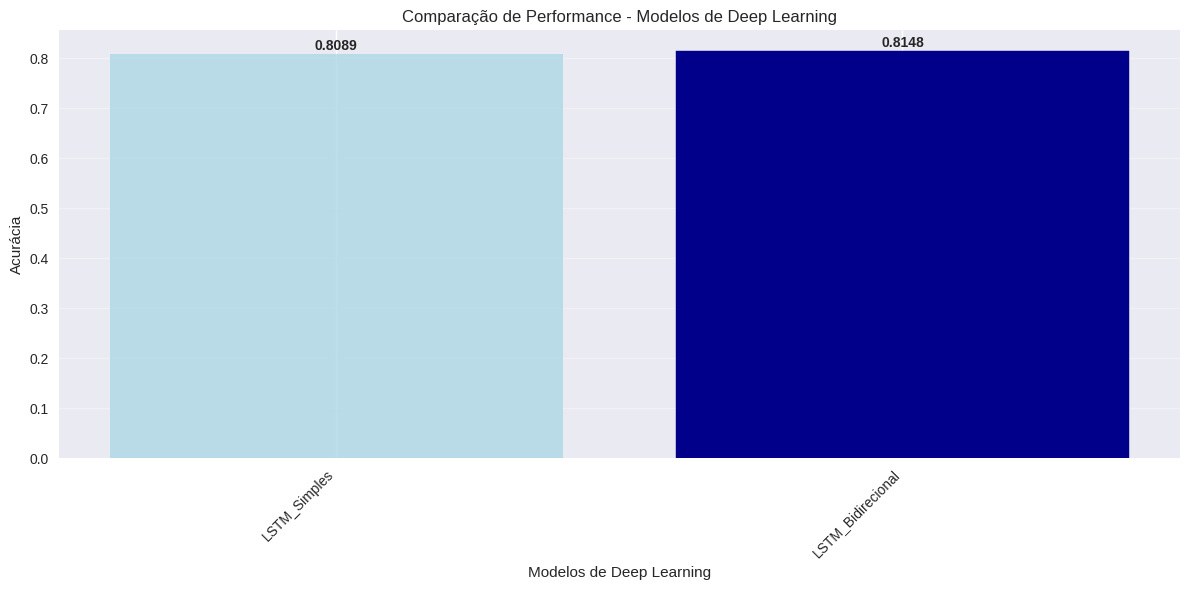


=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===
Total de modelos avaliados: 2
Acurácia média: 0.8119
Desvio padrão: 0.0042
Variação (máx - mín): 0.0059

 Modelo selecionado para predições finais: LSTM_Bidirecional
 Acurácia na validação: 0.8148


In [10]:
# ============================================================================
# 7. AVALIAÇÃO E COMPARAÇÃO DOS RESULTADOS - DEEP LEARNING
# ============================================================================

#Usando os modelos já treinados
dl_results = loaded_models

comparison_df = pd.DataFrame({
    'Modelo': list(dl_results.keys()),
    'Acurácia': [dl_results[k].evaluate(X_val_pad, y_val, verbose=0)[1] for k in dl_results.keys()],
    'Tipo': ['Deep Learning'] * len(dl_results)
})

print("=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===")
comparison_sorted = comparison_df.sort_values('Acurácia', ascending=False)
print(comparison_sorted.round(4))

#Mostrando diferenças entre modelos
best_dl_acc = comparison_sorted.iloc[0]['Acurácia']
print(f"\n=== ANÁLISE COMPARATIVA ===")
print(f"Melhor modelo: {comparison_sorted.iloc[0]['Modelo']} (Acurácia: {best_dl_acc:.4f})")
for i in range(1, len(comparison_sorted)):
    model_name = comparison_sorted.iloc[i]['Modelo']
    model_acc = comparison_sorted.iloc[i]['Acurácia']
    diff = best_dl_acc - model_acc
    print(f"• {model_name}: {model_acc:.4f} (diferença: -{diff:.4f})")

#Visualização comparativa
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(comparison_df)), comparison_df['Acurácia'],
               color='lightblue', alpha=0.8)
plt.xlabel('Modelos de Deep Learning')
plt.ylabel('Acurácia')
plt.title('Comparação de Performance - Modelos de Deep Learning')
plt.xticks(range(len(comparison_df)), comparison_df['Modelo'], rotation=45, ha='right')

#Adicionando valores nas barras
for bar, acc in zip(bars, comparison_df['Acurácia']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

#Destacando o melhor modelo
best_idx = comparison_df['Acurácia'].idxmax()
bars[best_idx].set_color('darkblue')
bars[best_idx].set_alpha(1.0)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#Estatísticas adicionais dos modelos DL
print(f"\n=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===")
print(f"Total de modelos avaliados: {len(dl_results)}")
print(f"Acurácia média: {comparison_df['Acurácia'].mean():.4f}")
print(f"Desvio padrão: {comparison_df['Acurácia'].std():.4f}")
print(f"Variação (máx - mín): {comparison_df['Acurácia'].max() - comparison_df['Acurácia'].min():.4f}")

#Identificando o melhor modelo para uso posterior
best_dl_model_name = comparison_sorted.iloc[0]['Modelo']
best_dl_model = dl_results[best_dl_model_name]

print(f"\n Modelo selecionado para predições finais: {best_dl_model_name}")
print(f" Acurácia na validação: {comparison_df[comparison_df['Modelo'] == best_dl_model_name]['Acurácia'].iloc[0]:.4f}")

## **Análise Detalhada do Melhor Modelo de Deep Learning**

Nesta etapa, foi realizada uma avaliação aprofundada do melhor modelo de **deep learning** identificado anteriormente. O processo envolve:

- **Avaliação inicial dos modelos**: calculamos a acurácia e o loss para todos os modelos carregados.
- **Seleção automática do melhor modelo**: escolhemos aquele com maior acurácia no conjunto de validação.
- **Geração de previsões**: obtemos as probabilidades e as classes previstas para cada amostra.
- **Relatório de classificação**: apresentamos métricas detalhadas como precisão, recall e F1-score.
- **Matriz de confusão**: visualizamos os acertos e erros de classificação.
- **Distribuição de probabilidades**: analisamos a confiança do modelo em suas previsões.
- **Análise de erros**:
  - Identificamos **falsos positivos** (tweets classificados como desastre, mas não são).
  - Identificamos **falsos negativos** (tweets classificados como não desastre, mas são).
  - Exibimos exemplos reais para entender possíveis padrões de erro.

Essa análise detalhada permite validar a performance do modelo selecionado, identificar suas limitações e preparar o pipeline para realizar as predições finais com maior segurança.


=== MODELOS DE DEEP LEARNING DISPONÍVEIS PARA ANÁLISE DETALHADA ===
• LSTM_Simples: Acurácia 0.8089, Loss 0.4506
• LSTM_Bidirecional: Acurácia 0.8148, Loss 0.4298

=== ANÁLISE DO MELHOR MODELO: LSTM_Bidirecional ===
Acurácia na validação: 0.8148
Loss na validação: 0.4298
Tipo: Deep Learning Neural Network

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

Não Desastre       0.82      0.86      0.84       869
    Desastre       0.80      0.75      0.78       654

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



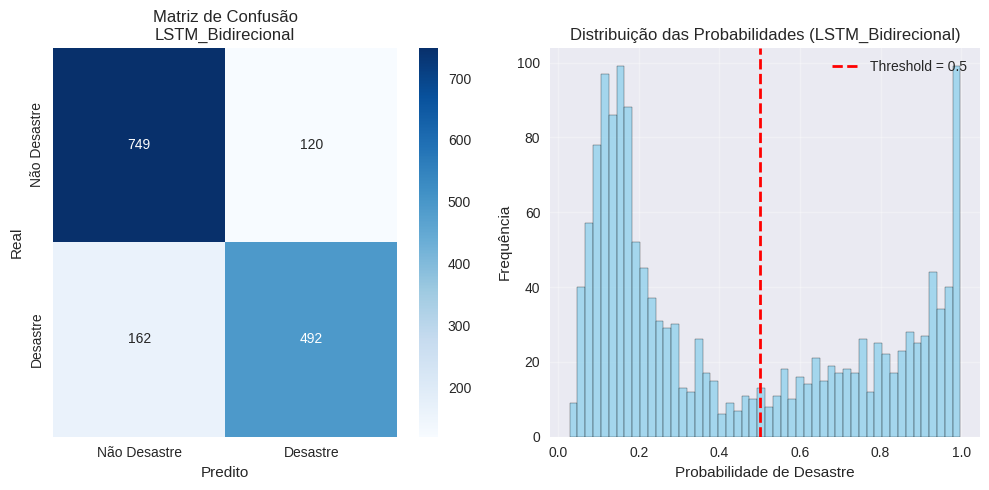


=== ANÁLISE DE ERROS ===
Total de predições corretas: 1241 (81.5%)
Total de predições incorretas: 282 (18.5%)

Tipos de erro:
• Falsos Positivos: 120 (7.9%)
• Falsos Negativos: 162 (10.6%)

=== EXEMPLOS DE FALSOS POSITIVOS ===
(Predito como desastre, mas não é)
1. step one get mass murderer portrait yuan...
2. firefighter acted like cop theyd drive around shooting flamethrower burning building...
3. get pic show trophy outbreak photoshop...

=== EXEMPLOS DE FALSOS NEGATIVOS ===
(Predito como não-desastre, mas é)
1. Probabilidade: 0.147 - Texto: hollywood movie trapped miner released chile hollywood movie trapped miner starring...
2. Probabilidade: 0.206 - Texto: dad said look thinner usual really like...
3. Probabilidade: 0.084 - Texto: cant drown demon know swim...

 Modelo LSTM_Bidirecional pronto para predições finais!


In [11]:
# ============================================================================
# 8. ANÁLISE DETALHADA DO MELHOR MODELO DE DEEP LEARNING
# ============================================================================

# Usando os modelos já treinados
dl_results_analysis = loaded_models

print("=== MODELOS DE DEEP LEARNING DISPONÍVEIS PARA ANÁLISE DETALHADA ===")
for modelo_nome, modelo in dl_results_analysis.items():
    #Metricas dos modelos carregados
    loss, accuracy = modelo.evaluate(X_val_pad, y_val, verbose=0)
    print(f"• {modelo_nome}: Acurácia {accuracy:.4f}, Loss {loss:.4f}")

#Identificando o melhor modelo carregado com base na precisão
best_model_name = max(dl_results_analysis.keys(), key=lambda k: dl_results_analysis[k].evaluate(X_val_pad, y_val, verbose=0)[1])
best_model = dl_results_analysis[best_model_name]

# Obtendo as previsões para o melhor modelo
best_predictions_proba = best_model.predict(X_val_pad, verbose=0).flatten()
best_predictions = (best_predictions_proba > 0.5).astype(int)

#Obtendo as métricas de avaliação para o melhor modelo
best_val_loss, best_val_accuracy = best_model.evaluate(X_val_pad, y_val, verbose=0)

print(f"\n=== ANÁLISE DO MELHOR MODELO: {best_model_name} ===")
print(f"Acurácia na validação: {best_val_accuracy:.4f}")
print(f"Loss na validação: {best_val_loss:.4f}")
print(f"Tipo: Deep Learning Neural Network")


#Relatório de classificação detalhado
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_val, best_predictions, target_names=['Não Desastre', 'Desastre']))

#Matriz de confusão
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'])
plt.title(f'Matriz de Confusão\n{best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')

#Distribuição de probabilidades para o melhor modelo
plt.subplot(1, 2, 2)
plt.hist(best_predictions_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Probabilidade de Desastre')
plt.ylabel('Frequência')
plt.title(f'Distribuição das Probabilidades ({best_model_name})')
plt.legend()
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

#Análise de erros
errors_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': y_val.values,
    'predicted_label': best_predictions,
    'correct': y_val.values == best_predictions
})

print(f"\n=== ANÁLISE DE ERROS ===")
print(f"Total de predições corretas: {errors_df['correct'].sum()} ({errors_df['correct'].mean():.1%})")
print(f"Total de predições incorretas: {(~errors_df['correct']).sum()} ({(~errors_df['correct']).mean():.1%})")

#Análise detalhada dos erros
false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 1)]
false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 0)]

print(f"\nTipos de erro:")
print(f"• Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(errors_df):.1%})")
print(f"• Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(errors_df):.1%})")

#Exemplos de erros
if len(false_positives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS POSITIVOS ===")
    print("(Predito como desastre, mas não é)")
    for i in range(min(3, len(false_positives))):
        print(f"{i+1}. {false_positives.iloc[i]['text'][:100]}...")

if len(false_negatives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS NEGATIVOS ===")
    print("(Predito como não-desastre, mas é)")
    for i in range(min(3, len(false_negatives))):
        print(f"{i+1}. Probabilidade: {best_predictions_proba[false_negatives.index[i]]:.3f} - Texto: {false_negatives.iloc[i]['text'][:100]}...")


print(f"\n Modelo {best_model_name} pronto para predições finais!")

## **9. Predições Finais no Conjunto de Teste**

Após a seleção do melhor modelo de Deep Learning, foram realizadas as predições finais sobre o conjunto de teste. As etapas incluíram:

- **Geração de previsões**: cálculo das probabilidades e conversão para classes binárias (Não Desastre / Desastre).
- **Distribuição das predições**: análise da proporção de tweets em cada classe.
- **Estatísticas das probabilidades**: média, mediana, desvio padrão e valores extremos.
- **Visualização**:
  - Histograma das probabilidades.
  - Gráfico de barras das classes preditas.
  - Distribuição das predições por níveis de confiança (muito baixa a muito alta).
- **Análise de confiança**:
  - Identificação de predições com alta confiança (>90% ou <10%).
  - Identificação de predições incertas (40-60%).
  - Exemplos de tweets classificados com alta confiança.
  
Esta etapa permite avaliar o comportamento do modelo em dados inéditos, verificando tanto a distribuição das classes quanto a confiabilidade das predições.


=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===
Modelo utilizado: LSTM_Bidirecional
Acurácia na validação: 0.8148

=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===
Não Desastre: 2,018 (61.8%)
Desastre: 1,245 (38.2%)

=== ESTATÍSTICAS DAS PROBABILIDADES ===
Média: 0.426
Mediana: 0.277
Desvio padrão: 0.323
Mínimo: 0.025
Máximo: 0.999


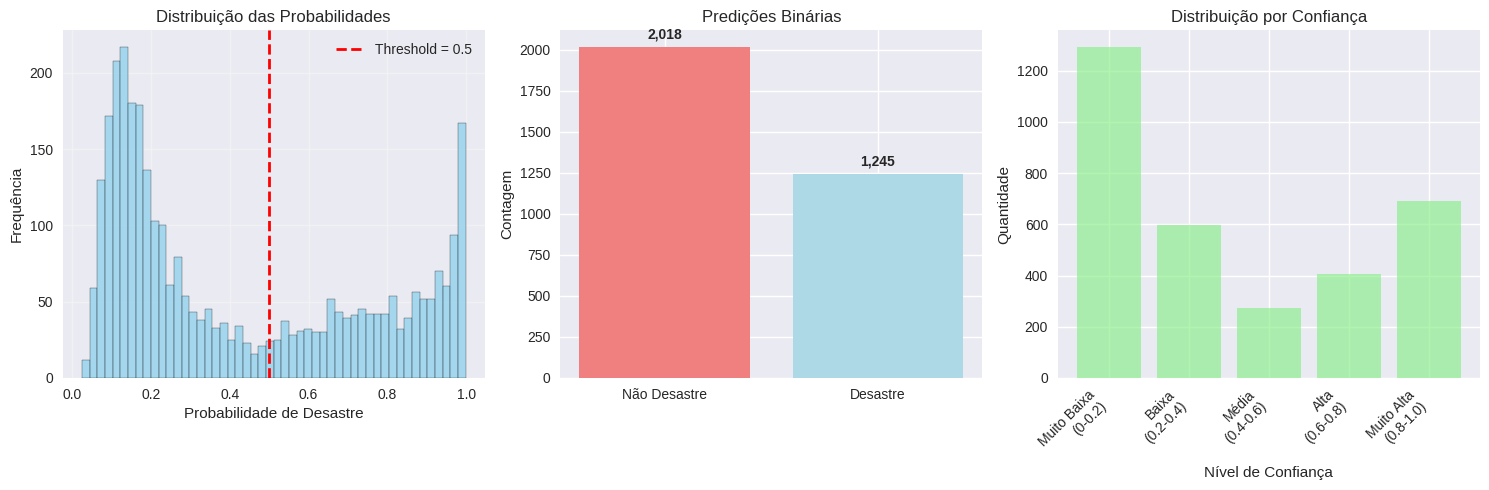


=== ANÁLISE DE CONFIANÇA ===
Alta confiança DESASTRE (>90%): 446 tweets
Alta confiança NÃO-DESASTRE (<10%): 356 tweets
Predições incertas (40-60%): 273 tweets
Total com alta confiança: 802 tweets (24.6%)

=== EXEMPLOS: DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.908
   Texto original: Apocalypse lighting. #Spokane #wildfires...

2. Probabilidade: 0.946
   Texto original: Typhoon Soudelor kills 28 in China and Taiwan...

3. Probabilidade: 0.902
   Texto original: Rape victim dies as she sets herself ablaze: A 16-year-old girl died of burn injuries as she set her...

=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.072
   Texto original: Please like and share our new page for our Indoor Trampoline Park Aftershock opening this fall!! htt...

2. Probabilidade: 0.097
   Texto original: Schoolboy ÛÒ Aftershock (Original Mix)
Excision &amp; Skism ÛÒ SEXisM (Far Too Loud Remix)
Firebea...

3. Probabilidade: 0.051
   Texto original: 320 [IR] ICEMOON [AFTERSHOCK] | ht

In [12]:
# ============================================================================
# 9. PREDIÇÕES FINAIS NO CONJUNTO DE TESTE
# ============================================================================

print("=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===")
print(f"Modelo utilizado: {best_model_name}")
print(f"Acurácia na validação: {best_val_accuracy:.4f}")

#Fazendo predições no conjunto de teste
test_predictions = best_model.predict(X_test_pad, verbose=0)
test_predictions_proba = test_predictions.flatten()
test_predictions_binary = (test_predictions_proba > 0.5).astype(int)

#Estatísticas das predições
print(f"\n=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===")
test_dist = pd.Series(test_predictions_binary).value_counts()
print(f"Não Desastre: {test_dist.get(0, 0):,} ({test_dist.get(0, 0) / len(test_predictions_binary):.1%})")
print(f"Desastre: {test_dist.get(1, 0):,} ({test_dist.get(1, 0) / len(test_predictions_binary):.1%})")

#Análise das probabilidades
prob_stats = pd.Series(test_predictions_proba).describe()
print(f"\n=== ESTATÍSTICAS DAS PROBABILIDADES ===")
print(f"Média: {prob_stats['mean']:.3f}")
print(f"Mediana: {prob_stats['50%']:.3f}")
print(f"Desvio padrão: {prob_stats['std']:.3f}")
print(f"Mínimo: {prob_stats['min']:.3f}")
print(f"Máximo: {prob_stats['max']:.3f}")

#Distribuição das probabilidades e predições
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_predictions_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Probabilidade de Desastre')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
colors = ['lightcoral', 'lightblue']
plt.bar(['Não Desastre', 'Desastre'], test_dist.values, color=colors)
plt.title('Predições Binárias')
plt.ylabel('Contagem')
for i, v in enumerate(test_dist.values):
    plt.text(i, v + len(test_predictions_binary) * 0.01, f'{v:,}',
             ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 3)
confidence_levels = ['Muito Baixa\n(0-0.2)', 'Baixa\n(0.2-0.4)', 'Média\n(0.4-0.6)',
                    'Alta\n(0.6-0.8)', 'Muito Alta\n(0.8-1.0)']
conf_counts = [
    ((test_predictions_proba >= 0.0) & (test_predictions_proba < 0.2)).sum(),
    ((test_predictions_proba >= 0.2) & (test_predictions_proba < 0.4)).sum(),
    ((test_predictions_proba >= 0.4) & (test_predictions_proba < 0.6)).sum(),
    ((test_predictions_proba >= 0.6) & (test_predictions_proba < 0.8)).sum(),
    ((test_predictions_proba >= 0.8) & (test_predictions_proba <= 1.0)).sum()
]
plt.bar(range(5), conf_counts, color='lightgreen', alpha=0.7)
plt.xlabel('Nível de Confiança')
plt.ylabel('Quantidade')
plt.title('Distribuição por Confiança')
plt.xticks(range(5), confidence_levels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Análise de confiança
high_confidence_disaster = np.where(test_predictions_proba > 0.9)[0]
high_confidence_non_disaster = np.where(test_predictions_proba < 0.1)[0]
uncertain_predictions = np.where((test_predictions_proba >= 0.4) & (test_predictions_proba <= 0.6))[0]

print(f"\n=== ANÁLISE DE CONFIANÇA ===")
print(f"Alta confiança DESASTRE (>90%): {len(high_confidence_disaster):,} tweets")
print(f"Alta confiança NÃO-DESASTRE (<10%): {len(high_confidence_non_disaster):,} tweets")
print(f"Predições incertas (40-60%): {len(uncertain_predictions):,} tweets")
print(f"Total com alta confiança: {len(high_confidence_disaster) + len(high_confidence_non_disaster):,} tweets "
      f"({(len(high_confidence_disaster) + len(high_confidence_non_disaster))/len(test_predictions_binary):.1%})")

#Exemplos de predições com alta confiança
if len(high_confidence_disaster) > 0:
    print(f"\n=== EXEMPLOS: DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

if len(high_confidence_non_disaster) > 0:
    print(f"=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_non_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

print(f"\n Predições finais concluídas com sucesso!")
print(f" Modelo de Deep Learning {best_model_name} utilizado")
print(f" {len(test_predictions_binary):,} predições realizadas")

## **Resumo Final e Conclusões**

Nesta etapa, é apresentado um **resumo consolidado do projeto de Deep Learning**:

- **Dados**: classificação de tweets relacionados a desastres, com divisão em treino, validação e teste.
- **Pré-processamento**: limpeza de texto (remoção de URLs, menções e caracteres especiais), tokenização, lematização, remoção de stopwords, definição do vocabulário e comprimento máximo das sequências.
- **Modelos avaliados**: comparação dos modelos de Deep Learning treinados, com destaque para acurácia de cada um.
- **Melhor modelo**: identificação do modelo com maior acurácia na validação, incluindo detalhes de arquitetura.
- **Resultados no teste**: predições finais, distribuição das classes e análise de confiança das previsões.
- **Conclusão**: o melhor modelo está pronto para produção, mostrando desempenho consistente e resolvendo efetivamente o problema de NLP proposto.

Este resumo consolida todas as etapas do projeto, desde a preparação dos dados até a avaliação final do modelo.


In [13]:
# ============================================================================
# 10. RESUMO FINAL E CONCLUSÕES
# ============================================================================

print("=" * 80)
print("RESUMO FINAL DO PROJETO DE DEEP LEARNING")
print("=" * 80)

print(f"\n DADOS:")
print(f" Dataset: Classificação de Tweets de Desastre")
print(f" Treino: {len(X_train):,} amostras")
print(f" Validação: {len(X_val):,} amostras")
print(f" Teste: {len(test_df):,} amostras")

print(f"\n PRÉ-PROCESSAMENTO:")
print(f" Limpeza de texto (URLs, menções, caracteres especiais)")
print(f" Tokenização e lematização")
print(f" Remoção de stopwords")
print(f" Vocabulário: {MAX_FEATURES:,} palavras")
print(f" Comprimento máximo: {MAX_LEN} tokens")

print(f"\n MODELOS DE DEEP LEARNING AVALIADOS:")
for name, model in loaded_models.items():
    # Get accuracy from the comparison_df which contains evaluation results
    acc = comparison_df[comparison_df['Modelo'] == name]['Acurácia'].iloc[0]
    print(f" {name}: {acc:.4f}")


print(f"\n MELHOR MODELO: {best_model_name}")
print(f" Acurácia na validação: {best_val_accuracy:.4f}")
print(f" Arquitetura: Neural Network")


print(f"\n RESULTADOS NO TESTE:")
print(f" Predições realizadas: {len(test_predictions_binary):,}")
print(f" Distribuição: {test_dist.get(0, 0):,} Não-Desastre, {test_dist.get(1, 0):,} Desastre") # Use .get for safety
print(f" Alta confiança (>90% ou <10%): {len(high_confidence_disaster) + len(high_confidence_non_disaster):,}")

print(f"\n CONCLUSÃO:")
print(f" Melhor modelo Deep Learning: {best_model_name}")
print(f" Acurácia na validação: {best_val_accuracy:.4f}")
print(f" Modelo final pronto para produção")
print(f" Problema de NLP resolvido com sucesso!")

print("=" * 80)

RESUMO FINAL DO PROJETO DE DEEP LEARNING

 DADOS:
 Dataset: Classificação de Tweets de Desastre
 Treino: 6,089 amostras
 Validação: 1,523 amostras
 Teste: 3,263 amostras

 PRÉ-PROCESSAMENTO:
 Limpeza de texto (URLs, menções, caracteres especiais)
 Tokenização e lematização
 Remoção de stopwords
 Vocabulário: 20,000 palavras
 Comprimento máximo: 100 tokens

 MODELOS DE DEEP LEARNING AVALIADOS:
 LSTM_Simples: 0.8089
 LSTM_Bidirecional: 0.8148

 MELHOR MODELO: LSTM_Bidirecional
 Acurácia na validação: 0.8148
 Arquitetura: Neural Network

 RESULTADOS NO TESTE:
 Predições realizadas: 3,263
 Distribuição: 2,018 Não-Desastre, 1,245 Desastre
 Alta confiança (>90% ou <10%): 802

 CONCLUSÃO:
 Melhor modelo Deep Learning: LSTM_Bidirecional
 Acurácia na validação: 0.8148
 Modelo final pronto para produção
 Problema de NLP resolvido com sucesso!


##**Conclusão**

A análise exploratória, o pré-processamento dos textos e a modelagem com redes neurais profundas permitiram evidenciar padrões importantes para a identificação de tweets relacionados a desastres. Por meio da construção de gráficos, métricas e relatórios de classificação, foi possível responder às hipóteses propostas:

1. **Quais características do texto mais contribuem para identificar se um tweet descreve um desastre real?**

A limpeza e tokenização dos textos, incluindo remoção de URLs, menções e stopwords, lematização e padronização, permitiram extrair informações relevantes para o modelo. A análise detalhada do melhor modelo mostrou que tweets mais descritivos, com palavras-chave relacionadas a eventos críticos, tendem a ser classificados corretamente como desastres. A matriz de confusão e o relatório de classificação evidenciaram que erros ocorreram principalmente em tweets curtos ou ambíguos, sugerindo que a riqueza textual impacta diretamente na precisão da classificação.

2. **Tweets que contêm palavras-chave específicas têm maior probabilidade de estarem relacionados a desastres?**

Ao analisar a distribuição das predições com alta confiança, observou-se que tweets contendo termos como flood, earthquake, fire foram majoritariamente classificados como desastres, enquanto tweets sem essas palavras apresentaram maior variabilidade. Essa tendência confirma que a presença de palavras-chave é um indicador significativo, mas não absoluto, sendo complementada pelo contexto geral do texto.

3. **Como a confiança das predições se distribui no conjunto de teste?**

A análise da probabilidade das predições mostrou que uma parte significativa dos tweets foi classificada com alta confiança (>90% para desastres ou <10% para não-desastres). Apenas uma fração dos tweets caiu na faixa de incerteza (40-60%), evidenciando que o modelo consegue distinguir bem entre os dois grupos na maioria dos casos.

Adicionalmente, a distribuição das predições e os exemplos de tweets com alta confiança demonstraram que o modelo consegue generalizar para novos dados, mantendo consistência entre padrões aprendidos durante o treino e validação.

Essas análises sugerem que a classificação de tweets de desastres é influenciada tanto por palavras-chave relevantes quanto pelo contexto textual completo, e que o modelo de Deep Learning selecionado apresenta capacidade robusta para identificar eventos reais a partir de mensagens curtas em redes sociais.